<a href="https://colab.research.google.com/github/ashbyp/mltorch/blob/master/colab/pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Intro

In [85]:
import torch
import sklearn
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)

print(len(X), len(y))
print(X[:5], type(X))
print(y[:5], type(y))

1000 1000
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]] <class 'numpy.ndarray'>
[1 1 1 1 0] <class 'numpy.ndarray'>


In [86]:
import pandas as pd

circles = pd.DataFrame({'X1': X[:, 0], 'X2': X[:, 1], 'label': y})
circles.head()


,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


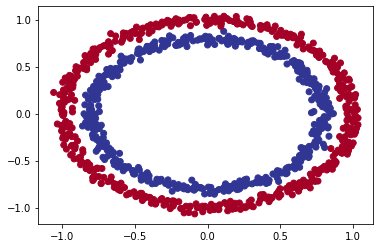

In [87]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

##Pre-process


In [88]:
print(f'X shape {X.shape} y shape: {y.shape}')

X shape (1000, 2) y shape: (1000,)


In [89]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
print(type(X), type(y))

<class 'torch.Tensor'> <class 'torch.Tensor'>


In [90]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
print(len(X_train), len(y_train), len(X_test), len(y_test))


800 800 200 200


##Build a model

In [91]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=5)
    self.layer2 = nn.Linear(in_features=5, out_features=1)


  def forward(self, x):
    return self.layer2(self.layer1(x))

model_0 = CircleModelV0().to(device)
print(model_0.state_dict())


OrderedDict([('layer1.weight', tensor([[-0.5988,  0.4893],
        [-0.1946, -0.2711],
        [-0.5869, -0.7030],
        [ 0.2023, -0.1545],
        [ 0.2753, -0.5803]], device='cuda:0')), ('layer1.bias', tensor([ 0.5250, -0.5191, -0.1221,  0.1477,  0.3650], device='cuda:0')), ('layer2.weight', tensor([[ 0.3610,  0.4074, -0.3546,  0.1125, -0.1924]], device='cuda:0')), ('layer2.bias', tensor([-0.0490], device='cuda:0'))])


In [92]:
# Easier model construction
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [93]:
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f'Predictions {len(untrained_preds)}\n', untrained_preds[:5])
print(f'Actuals {len(y_test)}', y_test[0:5])




Predictions 200
 tensor([[-0.1415],
        [-0.1357],
        [-0.0911],
        [-0.1561],
        [ 0.0132]], device='cuda:0')
Actuals 200 tensor([1., 0., 1., 0., 1.])


##Loss function and Optimizer

In [94]:
loss_fn = nn.BCEWithLogitsLoss() # sigmoid is built in
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

def accuracy_fn(y_true, y_pred):
  correct= torch.eq(y_true, y_pred).sum().item()
  return (correct/len(y_pred)) * 100.0




##Loop

In [95]:
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[0:5]
print(y_logits)

# logits are raw outputs of the model, we need to map to same format as labels,
# first step to to turn into preduction probabilities
y_pred_probs = torch.sigmoid(y_logits)
print(y_pred_probs)

# and can now round
print(torch.round(y_pred_probs))

tensor([[-0.1415],
        [-0.1357],
        [-0.0911],
        [-0.1561],
        [ 0.0132]], device='cuda:0')
tensor([[0.4647],
        [0.4661],
        [0.4772],
        [0.4611],
        [0.5033]], device='cuda:0')
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.]], device='cuda:0')


In [96]:
# full y preds chain is (logits->probs->labels)
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_0(X.to(device))))[0:5]
print(f'Untrained first 5: {y_preds.squeeze()}')

Untrained first 5: tensor([0., 0., 0., 0., 1.], device='cuda:0')


In [97]:
# Loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 100

X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), \
                                  X_test.to(device), y_test.to(device)

print(len(X_train), len(y_train), len(X_test), len(y_test))

epoch_counts = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):
  model_0.train()
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 10 == 0:
    print(f'Epoch: {epoch} Loss: {loss} Test loss: {test_loss} Accuracy: {test_acc}')

    epoch_counts.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)






800 800 200 200
Epoch: 0 Loss: 0.6944305300712585 Test loss: 0.6933614015579224 Accuracy: 45.5
Epoch: 10 Loss: 0.6939529776573181 Test loss: 0.6930894255638123 Accuracy: 48.0
Epoch: 20 Loss: 0.6936739087104797 Test loss: 0.6930163502693176 Accuracy: 48.5
Epoch: 30 Loss: 0.6934921145439148 Test loss: 0.6930305361747742 Accuracy: 47.0
Epoch: 40 Loss: 0.6933662295341492 Test loss: 0.693084716796875 Accuracy: 47.5
Epoch: 50 Loss: 0.693276047706604 Test loss: 0.6931571960449219 Accuracy: 46.0
Epoch: 60 Loss: 0.6932104229927063 Test loss: 0.6932368874549866 Accuracy: 45.0
Epoch: 70 Loss: 0.6931620836257935 Test loss: 0.693317711353302 Accuracy: 43.5
Epoch: 80 Loss: 0.6931261420249939 Test loss: 0.6933964490890503 Accuracy: 49.0
Epoch: 90 Loss: 0.6930992007255554 Test loss: 0.6934714317321777 Accuracy: 48.5


##Visualize

helper functions exists


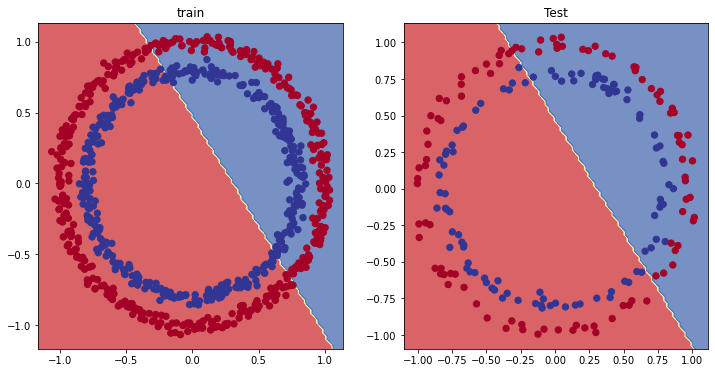

In [98]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
  print('helper functions exists')
else:
  print('Downloading helper functions')

request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
with open('helper_functions.py', "wb") as f:
  f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)


##Improve the model

800 800 200 200
Epoch: 0 Loss: 0.6939550638198853 Test loss: 0.6926146745681763 Accuracy: 51.0
Epoch: 100 Loss: 0.6930478811264038 Test loss: 0.6937904357910156 Accuracy: 48.0
Epoch: 200 Loss: 0.6929860711097717 Test loss: 0.6943727135658264 Accuracy: 46.0
Epoch: 300 Loss: 0.6929804682731628 Test loss: 0.6945767998695374 Accuracy: 45.0
Epoch: 400 Loss: 0.6929798722267151 Test loss: 0.6946452260017395 Accuracy: 46.0
Epoch: 500 Loss: 0.6929798722267151 Test loss: 0.6946680545806885 Accuracy: 46.0
Epoch: 600 Loss: 0.6929798722267151 Test loss: 0.6946756839752197 Accuracy: 46.0
Epoch: 700 Loss: 0.6929798722267151 Test loss: 0.6946782469749451 Accuracy: 46.0
Epoch: 800 Loss: 0.6929798722267151 Test loss: 0.6946790814399719 Accuracy: 46.0
Epoch: 900 Loss: 0.6929798722267151 Test loss: 0.6946793794631958 Accuracy: 46.0


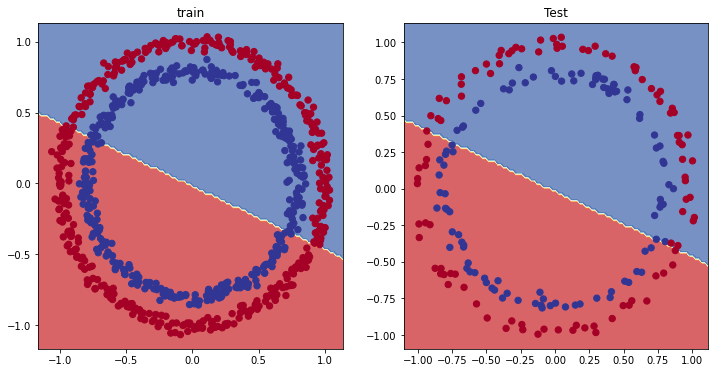

In [99]:
# mode layers, nodes, epochs

class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

loss_fn = nn.BCEWithLogitsLoss() #
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 1000

X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), \
                                  X_test.to(device), y_test.to(device)

print(len(X_train), len(y_train), len(X_test), len(y_test))

epoch_counts = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):
  model_1.train()
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 100 == 0:
    print(f'Epoch: {epoch} Loss: {loss} Test loss: {test_loss} Accuracy: {test_acc}')

    epoch_counts.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)



##Include non-linear activations

800 800 200 200
Epoch: 0 Loss: 0.6944792866706848 Test loss: 0.691973090171814 Accuracy: 54.0
Epoch: 100 Loss: 0.69101881980896 Test loss: 0.6896095275878906 Accuracy: 56.49999999999999
Epoch: 200 Loss: 0.687498927116394 Test loss: 0.6870446801185608 Accuracy: 56.99999999999999
Epoch: 300 Loss: 0.683785080909729 Test loss: 0.6835703253746033 Accuracy: 59.5
Epoch: 400 Loss: 0.6782140731811523 Test loss: 0.6780723333358765 Accuracy: 63.0
Epoch: 500 Loss: 0.6689785122871399 Test loss: 0.6691297888755798 Accuracy: 72.0
Epoch: 600 Loss: 0.6529247760772705 Test loss: 0.6543256044387817 Accuracy: 77.0
Epoch: 700 Loss: 0.6231433749198914 Test loss: 0.6275258660316467 Accuracy: 84.0
Epoch: 800 Loss: 0.5653852820396423 Test loss: 0.5762335658073425 Accuracy: 94.0
Epoch: 900 Loss: 0.45988211035728455 Test loss: 0.48168236017227173 Accuracy: 98.0
Epoch: 1000 Loss: 0.31106042861938477 Test loss: 0.34225425124168396 Accuracy: 100.0
Epoch: 1100 Loss: 0.6622210741043091 Test loss: 0.70357346534729 Acc

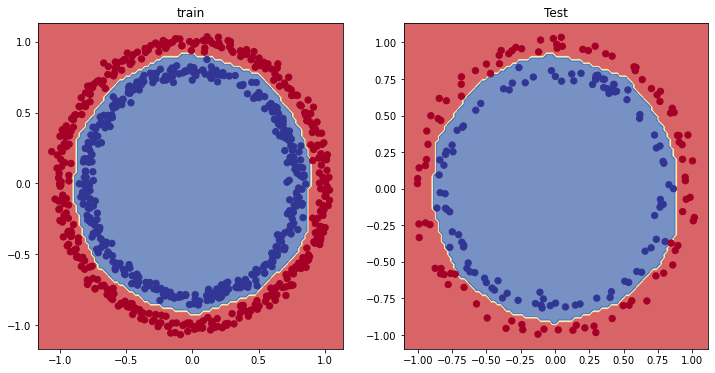

In [100]:
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=20)
        self.layer_2 = nn.Linear(in_features=20, out_features=20)
        self.layer_3 = nn.Linear(in_features=20, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
       
    def forward(self, x):
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_2 = CircleModelV2().to(device)
model_2

loss_fn = nn.BCEWithLogitsLoss() #
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 3000

X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), \
                                  X_test.to(device), y_test.to(device)

print(len(X_train), len(y_train), len(X_test), len(y_test))

epoch_counts = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):
  model_2.train()
  y_logits = model_2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_logits = model_2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 100 == 0:
    print(f'Epoch: {epoch} Loss: {loss} Test loss: {test_loss} Accuracy: {test_acc}')

    epoch_counts.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('train')
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_2, X_test, y_test)


##Replicating non-linear activation functions

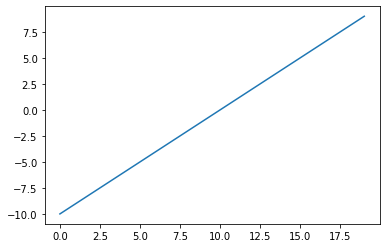

In [101]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
plt.plot(A)

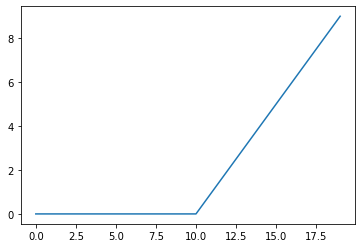

In [102]:
def my_relu(x):
  return torch.maximum(torch.tensor(0), x)

plt.plot(my_relu(A))

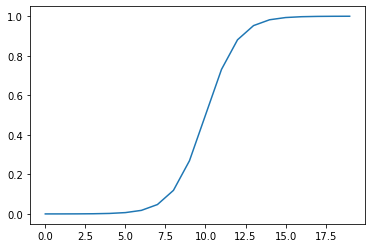

In [103]:
def my_sigmoid(x):
  return 1 / (1 + torch.exp(-x))

plt.plot(my_sigmoid(A))

##Multi class classification

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]])
tensor([-8.4134, -5.7665, -6.0421,  3.9508,  4.2505])
tensor([ 6.9352, -6.4312, -6.7661,  0.6984, -0.2815])


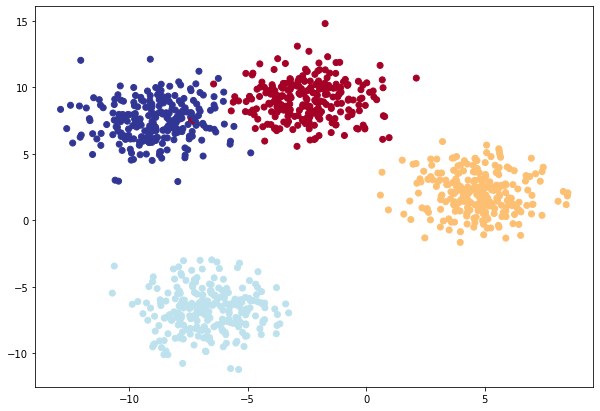

In [104]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_features=NUM_FEATURES, 
                            n_samples=1000,
                            centers=NUM_CLASSES,
                            random_state=RANDOM_SEED,
                            cluster_std=1.5)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

print(X_blob[0:5])
print(X_blob[0:5, 0])
print(X_blob[0:5, 1])

X_blob_train, X_blob_test, y_blob_train, y_blob_test =\
 train_test_split(X_blob, y_blob, test_size=.2, random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)


In [105]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cuda'

In [106]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_3 = BlobModel(2, 4).to(device)
model_3

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [109]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)


In [117]:
model_3.eval()
with torch.inference_mode():
  y_logits = model_3(X_blob_test.to(device))
print(y_logits[0:5])
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_pred_probs[0:5])
print(torch.argmax(y_pred_probs[0])) # MAP TO TARGET LABELS 

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')
tensor(1, device='cuda:0')


##Training a testing loop for multiclass model